# Second-level group analysis

## Data load

We are also simultaneously going to combine the results from certain peaks

In [194]:
import pandas as pd
from pathlib import Path

# Peaks to combine
peaks_comb = [['PCh','GPC'],
              ['Cr','PCr'],
              ['NAA', 'NAAG'],
              ['Glu', 'Gln']]

In [215]:
# Utility functions
def comb_peaks_init(dfin):
    for peaks in peaks_comb:
        comb_val = dfin[[f"conc_{peaks[0]}", f"conc_{peaks[1]}"]].sum(axis=1)
        dfin[f'conc_{peaks[0]}+{peaks[1]}'] = comb_val
    return dfin

def comb_peaks(dfin, cov):
    comb_peaks_df = [dfin]
    for peaks in peaks_comb:
        comb_mean = dfin['mean'].filter(regex=f"_{peaks[0]}_", axis=0)\
            + dfin['mean'].filter(regex=f"_{peaks[1]}_", axis=0).values
        tmp_cov = cov.filter(regex=f"_{peaks[0]}_", axis=0)\
                     .filter(regex=f"_{peaks[1]}_", axis=1).to_numpy()
        id_mats = np.tile(
            np.eye(tmp_cov.shape[1]),
            (int(tmp_cov.shape[0]/tmp_cov.shape[1]), 1))
        cov_vec = (tmp_cov * id_mats).sum(axis=1)
        comb_std = (dfin['sd'].filter(regex=f"_{peaks[0]}_", axis=0).pow(2)\
            + dfin['sd'].filter(regex=f"_{peaks[1]}_", axis=0).pow(2).values\
            + 2 * cov_vec\
            ).pow(0.5)

        comb_mean = pd.concat([comb_mean, comb_std],keys=('mean','sd'),axis=1)
        comb_mean.index = comb_mean.index.map(lambda x: (x[0], x[1], x[2].replace(f'{peaks[0]}',f'{peaks[0]}+{peaks[1]}')))
        comb_peaks_df.append(comb_mean)
    return pd.concat(comb_peaks_df)

def load_fitted_data(path):
    sub_order = []
    stim_type = []
    df_container = []
    df_init_container = []
    cov_container = []
    for file in path.rglob('free_parameters.csv'):
        stim_type.append(file.parent.stem)
        sub_order.append(file.parent.parent.stem)
        df = pd.read_csv(file, index_col=0)
        df_container.append(df)

        df_init = pd.read_csv(file.parent / 'init_results.csv',index_col=0)
        df_init_container.append(df_init)

        cov_container.append(
            pd.read_csv(file.parent / 'dyn_cov.csv', index_col=0))

    mindex = pd.MultiIndex.from_arrays((stim_type, sub_order))
    combined_dyn_df = pd.concat(df_container, axis=0, keys=mindex)
    combined_init_df = pd.concat(df_init_container, axis=0,keys=mindex).fillna(0)
    combined_cov = pd.concat(cov_container, axis=0, keys=mindex).fillna(0)
    return combined_dyn_df, comb_peaks_init(combined_init_df), combined_cov

In [218]:
dyn_df, init_df, cov_df = load_fitted_data(Path('first_level_results'))


## Analysis using FSL's FLAME tool

In [100]:
# More utility functions wrapping FLAMEO
import tempfile
from fsl.data.vest import generateVest
from fsl.data.image import Image
import os
import numpy as np

def flameo_wrapper(cope, varcope, mats=None):
    """Wrapper around flameo

    cope, varcope : numpy array (subjects x params)
    mats : dict. 
        default is  mats['desmat'] = ones(N,1), 
                    mats['conmat'] = 1
                    mats['covmat'] = ones(N,1)
    """
    tmp = tempfile.NamedTemporaryFile().name
    nsubjects = cope.shape[0]
    nparams   = cope.shape[1]
    if mats is None:
        
        mats = {'desmat':np.ones((nsubjects,1)), 
                'conmat':np.ones((1,1)),
                'covmat':np.ones((nsubjects,1))}

    # generate vest files
    for f,m in mats.items():    
        with open(tmp+f, "w") as txtfile:
            txtfile.write(generateVest(m))

    # save image files
    cope    = np.reshape(cope.T,(nparams,1,1,nsubjects))
    varcope = np.reshape(varcope.T,(nparams,1,1,nsubjects))
    img = Image(cope)
    img.save(tmp+'cope')
    img = Image(varcope)
    img.save(tmp+'varcope')
    img = Image(1+0*cope[:,:,:,0])
    img.save(tmp+'mask')

    # run flameo
    os.system('rm -rf {tmp}dir')
    command=f'flameo --ld={tmp}dir --cope={tmp}cope --varcope={tmp}varcope --mask={tmp}mask --dm={tmp}desmat --tc={tmp}conmat --cs={tmp}covmat --runmode=flame1 --sdof=-1 > /dev/null'
    os.system(command)
        
    # collect results
    z = Image(f'{tmp}dir/zstat1')
    z =z.data[:,0,0]
    out_cope = Image(f'{tmp}dir/cope1').data[:,0,0]
    out_varcope = Image(f'{tmp}dir/varcope1').data[:,0,0]
    
    return z, out_cope, out_varcope

We now define a function that will combine regressor beta values to tell us whether a mean activation has taken place.

In [224]:
import scipy.stats
import re


def calc_stats(df_in, cov_in):
    cope = df_in['mean'].unstack().sort_index().copy()
    varcope = df_in['sd'].pow(2).unstack().sort_index().copy()

    metab_names = list(set([re.match(r'conc_([\w|\+]+)_beta\d',ss)[1] for ss in cope.filter(like='conc').columns.to_list()]))

    # Combine Beta0 and Beta1 (two Stim periods) to give mean activations
    for met in metab_names:
        beta_list = [f'conc_{met}_beta0', f'conc_{met}_beta1']
        cope[f'mean_{met}'] = cope[beta_list].mean(axis=1)
        
        tmp_df = cov_in.loc[(slice(None), beta_list), beta_list]
        varcope[f'mean_{met}'] = tmp_df.multiply(0.25).groupby(level=0).sum().sum(axis=1)

    # Combine results from correlated peaks e.g. NAA and NAAG
    for cp in peaks_comb:
        for idx in range(4):
            beta_list = []
            met_name = 'conc_'
            for met in cp:
                beta_list.append(f'conc_{met}_beta{idx}')
                met_name += f'{met}+'
            met_name = met_name.rstrip('+')
            met_name += f'_beta{idx}'

            cope[met_name] = cope[beta_list].sum(axis=1)
            tmp_df = cov_in.loc[(slice(None), beta_list), beta_list]
            varcope[met_name] = tmp_df.groupby(level=0).sum().sum(axis=1)
    
    # Also combine the Beta0 and Beta1 in those combined peaks
    for cp in peaks_comb:
        beta_list = []
        met_name = 'mean_'
        for met in cp:
            beta_list.extend([f'conc_{met}_beta0', f'conc_{met}_beta1'])
            met_name += f'{met}+'
        met_name = met_name.rstrip('+')
        cope[met_name] = cope[beta_list].sum(axis=1) / 2
        tmp_df = cov_in.loc[(slice(None), beta_list), beta_list]
        varcope[met_name] = tmp_df.multiply(0.25).groupby(level=0).sum().sum(axis=1)

    if 'sigma_beta0_0' in cope.columns:
        cope['mean_sigma_0'] = \
            (cope['sigma_beta0_0'] \
            + cope['sigma_beta1_0'] )/2.0
        covar = cov_in['sigma_beta0_0'].loc[:,'sigma_beta1_0']
        varcope['mean_sigma_0'] = \
            (varcope['sigma_beta0_0'] \
            + varcope['sigma_beta1_0'] \
            + 2 * covar \
            )/4.0
        
    z, out_cope, out_varcope  = flameo_wrapper(cope.to_numpy(), varcope.to_numpy())

    z_df = pd.Series(z, index=varcope.columns)
    cope_df = pd.Series(out_cope, index=varcope.columns)
    varcope_df = pd.Series(out_varcope, index=varcope.columns)
    p_df = pd.Series(scipy.stats.norm.sf(z_df.abs().to_numpy()), index=varcope.columns)
    return pd.concat(
        [cope_df,
         varcope_df,
         z_df,
         p_df],
        axis=1, keys=['COPE', 'VARCOPE', 'z', 'p'])

pd.options.mode.chained_assignment = None
def format_df(df_in, metabs_to_plot=None):
    var_tmp = df_in\
    .loc[~(df_in.index.str.contains('_NAA$', case=False)\
        |df_in.index.str.contains('_NAAG$', case=False)\
        |df_in.index.str.contains('_Cr$', case=False)\
        |df_in.index.str.contains('_PCr$', case=False)\
        |df_in.index.str.contains('_PCh$', case=False)\
        |df_in.index.str.contains('_GPC$', case=False)),:]

    var_to_plot = var_tmp.filter(regex='mean_(?!sigma)',axis=0)
    var_to_plot.index = var_to_plot.index.str.replace('mean_','')

    tmp_means = var_tmp.filter(regex='(?<!sigma_)beta3',axis=0).COPE.abs()
    tmp_means.index = tmp_means.index.str.replace('conc_','')
    tmp_means.index = tmp_means.index.str.replace('_beta3','')

    var_to_plot.COPE = var_to_plot.COPE.divide(tmp_means).multiply(100)
    var_to_plot.VARCOPE = var_to_plot.VARCOPE.pow(0.5).divide(tmp_means).multiply(100)

    var_to_plot = var_to_plot.sort_index()

    var_to_plot = var_to_plot.rename(columns={'COPE':'Effect(%)','VARCOPE':'SD(%)'})

    if metabs_to_plot:
        var_to_plot = var_to_plot.loc[metabs_to_plot]

    return var_to_plot.style\
    .format(formatter={'Effect(%)': "{:+06.2f}",
                       'SD(%)': "{:04.1f}",
                       'z':    "{:+05.2f}",
                       'p':    "{:05.3f}"})\
    .highlight_between(subset=['p'],left=0, right=0.05, props='font-weight:bold;color:#e83e8c')\
    .set_table_attributes("style='display:inline'")
#    .background_gradient(subset=['p'], cmap='PuBu_r')\
#     .background_gradient(subset=['z'], cmap='RdBu')\

stats = {} 
stats['stim'] = calc_stats(dyn_df.loc['stim'], cov_df.loc['stim'])
stats['ctrl'] = calc_stats(dyn_df.loc['ctrl'], cov_df.loc['ctrl'])

format_df(stats['stim'])

,Effect(%),SD(%),z,p
Asc,+01.41,02.8,+0.49,0.313
Asp,-02.32,01.5,-1.44,0.075
Cr+PCr,-00.06,00.2,-0.36,0.358
GABA,-02.37,06.1,-0.37,0.354
GSH,+00.39,01.4,+0.26,0.397
Glc,-31.13,04.4,-4.00,0.000
Gln,+01.97,01.4,+1.26,0.103
Glu,+02.77,00.5,+3.46,0.000
Glu+Gln,+02.58,00.3,+4.30,0.000
Ins,-00.20,00.3,-0.67,0.251


In [212]:
format_df(stats['ctrl'])

,Effect(%),SD(%),z,p
Asc,-01.53,02.8,-0.53,0.297
Asp,+01.48,01.6,+0.87,0.193
Cr+PCr,-00.11,00.2,-0.65,0.257
GABA,+07.10,06.4,+1.04,0.149
GSH,-00.49,01.4,-0.34,0.366
Glc,+00.37,05.4,+0.07,0.473
Gln,+00.86,01.4,+0.60,0.276
Glu,-00.45,00.4,-1.14,0.126
Glu+Gln,-00.13,00.3,-0.40,0.344
Ins,+00.36,00.3,+1.20,0.115


## Plotting functions
Plotting functions for data exploration

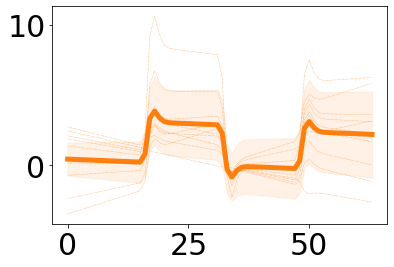

In [222]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

design_matrix = pd.read_csv('designmat.csv',header=None).to_numpy()


def plot_2ndlvl(metab, df, percent=True):
    """Returns the temporal response of a metabolite or other free parameter

    :param metab: Regex search string for filtering GLM fitted metabolite/parameter
    :type metab: str
    :param df: stats dataframe
    :type df: pd.DataFrame
    :param percent: Scale to constant beta in %, defaults to True
    :type percent: bool, optional
    """
    currcopes = df.filter(regex=metab, axis=0).COPE
    curr95ci = df.filter(regex=metab, axis=0).VARCOPE.pow(0.5)
    curr95ci_low = currcopes - curr95ci
    curr95ci_high = currcopes + curr95ci

    constant_term = f'_beta{design_matrix.shape[1]-1}'

    if percent:      
        curr95ci_low = (curr95ci_low / currcopes.filter(regex=constant_term, axis=0).to_numpy())
        curr95ci_low = curr95ci_low.to_numpy()
        
        curr95ci_high = (curr95ci_high / currcopes.filter(regex=constant_term, axis=0).to_numpy())
        curr95ci_high = curr95ci_high.to_numpy()
        
        currcopes = (currcopes / currcopes.filter(regex=constant_term, axis=0).to_numpy())
        currcopes = currcopes.to_numpy()
        return 100 * (np.dot(design_matrix,currcopes)  - 1.0)\
             , 100 * (np.dot(design_matrix,curr95ci_low)  - 1.0)\
             , 100 * (np.dot(design_matrix,curr95ci_high)  - 1.0)
    else:
        currcopes = currcopes.to_numpy()
        curr95ci_low = curr95ci_low.to_numpy()
        curr95ci_high = curr95ci_high.to_numpy()
        return np.dot(design_matrix,currcopes), np.dot(design_matrix,curr95ci_low), np.dot(design_matrix,curr95ci_high)

def indiv_traces(metab, df, percent=True):
    vals = []
    for subj in df.index.unique(level=0):
        p = df.loc[subj].filter(regex=metab, axis=0)['mean'].values
        val = np.dot(p, design_matrix.T)
        if percent:
            val = 100 * val/p[-1] - 100
        vals.append(val)
    return vals

## Plot 

colors = plt.get_cmap('tab10').colors
t_axis = np.arange(0,64)

# Plot glutamate response
met = 'Glu'
plt.plot(plot_2ndlvl(f'_{met}_', stats['stim'])[0], color=colors[1], label=met, linewidth=5)
plt.fill_between(
    t_axis,
    plot_2ndlvl(f'_{met}_', stats['stim'])[1],
    plot_2ndlvl(f'_{met}_', stats['stim'])[2],
    color=colors[1],
    alpha=0.1)

for it in indiv_traces(f'_{met}_', dyn_df.loc['stim'], percent=True):
    plt.plot(it, linestyle=':', color=colors[1], linewidth=0.5)



In [236]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

colors = plt.get_cmap('tab10').colors
def color_t2s(tin, alpha=1):
    tscaled = [255*t for t in tin]
    return f'rgba({tscaled[0]}, {tscaled[1]}, {tscaled[2]}, {alpha})'
line_size = dict(data=3, indivdata=0.5)

open_or_closed = 'stim'
metab_list = ['NAA+NAAG', 'PCh+GPC', 'Cr+PCr', 'Glu', 'Asp', 'Lac', 'Glc']
# metab_list = ['NAA+NAAG', 'NAAG', 'NAA']

comb_df = comb_peaks(dyn_df, cov_df)

traces = []
axis = np.arange(1, 65)
for idx, met in enumerate(metab_list):
    regexstr = f'_{met}_'
    regexstr = regexstr.replace('+', '\+')
    data = plot_2ndlvl(regexstr, stats[open_or_closed])
    mean_trace = go.Scatter(x=axis, y=data[0],
                mode='lines',
                name=met,
                legendgroup=met,
                line=dict(
                    color=color_t2s(colors[idx]),
                    width=line_size['data']),
                )
    traces.append(mean_trace)
    errors = go.Scatter(
        x=np.concatenate((axis, axis[::-1])) , # x, then x reversed
        y=np.concatenate((data[2], data[1][::-1])), # upper, then lower reversed
        fill='toself',
        fillcolor=color_t2s(colors[idx], 0.2),
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        name=met + ' CI',
        legendgroup=met,
        showlegend=False
    )
    traces.append(errors)
    for jdx, it in enumerate(indiv_traces(regexstr, comb_df.loc[open_or_closed], percent=True)):
        ind_trace = go.Scatter(
            x=axis, y=it,
            mode='lines',
            name=met + f'_S{jdx}',
            legendgroup=met,
            line=dict(
                color=color_t2s(colors[idx],0.5),
                width=line_size['indivdata']),
            showlegend=False)
        traces.append(ind_trace)

fig = make_subplots(rows=2, cols=1,
                row_heights=[0.6, 0.4],
                vertical_spacing=0.1,
                specs=[[{'type': 'scatter'}], [{'type': 'scatter'}]])

for trace in traces:
    fig.add_trace(trace, row=1, col=1)

lw_traces = []
data = plot_2ndlvl('sigma_0_', stats[open_or_closed], percent=False)
lw_traces.append(go.Scatter(x=axis, y=data[0]/np.pi,
            mode='lines',
            name='lw: sigma',
            legendgroup='sigma',
            line=dict(
                color=color_t2s((0,0,0)),
                width=line_size['data']),
            ))
lw_traces.append(go.Scatter(
        x=np.concatenate((axis, axis[::-1])) , # x, then x reversed
        y=np.concatenate((data[2], data[1][::-1]))/np.pi, # upper, then lower reversed
        fill='toself',
        fillcolor=color_t2s((0,0,0), 0.2),
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        name='lw: sigma CI',
        legendgroup='sigma',
        showlegend=False
    ))
for jdx, it in enumerate(indiv_traces('sigma_0_', comb_df.loc[open_or_closed], percent=False)):
    lw_traces.append(go.Scatter(
        x=axis, y=it/np.pi,
        mode='lines',
        name=f'lw: sigma_S{jdx}',
        legendgroup='sigma',
        line=dict(
            color=color_t2s((0,0,0),0.5),
            width=line_size['indivdata']),
        showlegend=False))

for trace in lw_traces:
    fig.add_trace(trace, row=2, col=1)


fig.update_layout(template='plotly_white')

fig.update_xaxes(
    row=1,
    tick0=0, dtick=16,
    range=[0, 65])
fig.update_xaxes(
    row=2,
    title_text='Transient #',
    tick0=0, dtick=16,
    range=[0, 65])

fig.update_yaxes(row=1,
                title_text='% change',
                zeroline=True,
                zerolinewidth=0.5,
                zerolinecolor='Gray',
                range=[-15, 15])

fig.update_yaxes(row=2,
                title_text='Gaussian Linewidth (Hz)',
                range=[3.5, 5.5])


fig.layout.update({'height': 700})
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
)
fig